# Notebook 3: Model Setup and Evaluation

## Introduction

In this notebook, we will use the dataset prepared in notebook 2 to begin the modelling process to predict the rating of the restaurant. 

## Methodology

In this notebook, we preprocess our dataset to make it compatible with machine learning models.



## Data Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook.

In [1]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SciPy modules
from scipy import stats
from scipy.sparse import csr_matrix

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sklearn modules
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

# XGBooost
from xgboost import XGBRegressor


# Python string package
import string

# NLTK for NLP purposes
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Gensim for utilizing word embeddings
import gensim
from gensim.utils import simple_preprocess

# Joblib for pickling purposes
import joblib


# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in Dataset

We now read in the review dataset that was cleaned in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Mexican,Bakeries,Japanese,Delis,Specialty Food,stars,text,reviews_per_week,repeat_customers,number_of_branches
0,2016-03-07 17:58:53,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,0,0,0,4,Pizza here is delicious. I tried it once a few...,0.057097,0,1
1,2010-01-10 17:33:51,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,0,0,0,4,love this place! really good pizza and probabl...,0.057097,0,1
2,2007-12-30 15:51:13,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,0,0,0,4,"Go up route one, get off on Lowell street head...",0.057097,0,1
3,2016-10-17 22:37:50,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,0,0,0,1,Tonight was the first and last time we will or...,0.057097,0,1
4,2018-03-09 00:32:31,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,0,0,0,5,Salads are actually green and hearty!\nPita po...,0.057097,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   review_count                1364840 non-null  int64  
 4   is_open                     1364840 non-null  int64  
 5   RestaurantsGoodForGroups    1364840 non-null  int64  
 6   HasTV                       1364840 non-null  int64  
 7   GoodForKids                 1364840 non-null  int64  
 8   RestaurantsTakeOut          1364840 non-null  int64  
 9   RestaurantsPriceRange2      1364840 non-null  int64  
 10  RestaurantsReservations     1364840 non-null  int64  
 11  RestaurantsAttire           1364840 non-null  object 
 12  RestaurantsDelivery         1364840 non-null  int64  
 1

We have some `object` data type columns that we need to preprocess in order to make it compatible with the machine learning models that we will train in this notebook. We can break down the `date` column into separate numeric columns. The remaining `object` type columns, namely `RestaurantsAttire`, `NoiseLevel`, `Alcohol`, `WiFi`, and `text` will be converted to numeric columns using specific column transformers.

### Converting Date Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.insert(loc=0, column='Year', value=df['date'].dt.year)
df.insert(loc=1, column='Month', value=df['date'].dt.month)
df.insert(loc=2, column='Day', value=df['date'].dt.day)
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday)
df.insert(loc=4, column='Hour', value=df['date'].dt.hour)
df.insert(loc=5, column='Minute', value=df['date'].dt.minute)
df.drop('date', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 48 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

In [5]:
df['NoiseLevel'].unique().tolist()

['average', 'quiet', 'loud', 'very_loud']

In [6]:
df['NoiseLevel'] = df['NoiseLevel'].map({'average': 1, 'quiet': 2, 'loud': 3, 'very_loud': 4})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 48 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

### Get Dummies

In [8]:
# Get  columns whose data type is object
object_columns = df.drop('text', axis=1).dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'Alcohol', 'WiFi']

In [9]:
temp_df = pd.get_dummies(df[object_columns], drop_first=True)
temp_df.head()

,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [10]:
df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,text,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,Pizza here is delicious. I tried it once a few...,0.057097,0,1,0,0,0,1,0,0
1,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,love this place! really good pizza and probabl...,0.057097,0,1,0,0,0,1,0,0
2,2007,12,30,6,15,51,42.541155,-70.973438,39,1,...,"Go up route one, get off on Lowell street head...",0.057097,0,1,0,0,0,1,0,0
3,2016,10,17,0,22,37,42.541155,-70.973438,39,1,...,Tonight was the first and last time we will or...,0.057097,0,1,0,0,0,1,0,0
4,2018,3,9,4,0,32,42.541155,-70.973438,39,1,...,Salads are actually green and hearty!\nPita po...,0.057097,0,1,0,0,0,1,0,0


In [11]:
temp_df = df[['text']]
df = pd.concat([df.drop('text', axis=1), temp_df], axis=1)
df.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Pizza here is delicious. I tried it once a few...
1,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,love this place! really good pizza and probabl...
2,2007,12,30,6,15,51,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,"Go up route one, get off on Lowell street head..."
3,2016,10,17,0,22,37,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Tonight was the first and last time we will or...
4,2018,3,9,4,0,32,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Salads are actually green and hearty!\nPita po...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

### Ordering the columns

We will be using a column transformer later in this notebook to apply specific transformations to certain columns based on their data type and the information that each contains. Hence, it will be convenient to reorder the columns in a convenient order, based on the order the column transformations will be applied. For now, we will move all columns of the `object` data type to the end of the data frame. 

### Define X and y

We are now ready to define our independent variable array `X` and our dependent variable `y`. Our dependent variable is the number of stars (i.e. the `stars` column).

In [13]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Pizza here is delicious. I tried it once a few...
1,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,love this place! really good pizza and probabl...
2,2007,12,30,6,15,51,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,"Go up route one, get off on Lowell street head..."
3,2016,10,17,0,22,37,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Tonight was the first and last time we will or...
4,2018,3,9,4,0,32,42.541155,-70.973438,39,1,...,0.057097,0,1,0,0,0,1,0,0,Salads are actually green and hearty!\nPita po...


In [14]:
y = df['stars']
y.head()

0    4
1    4
2    4
3    1
4    5
Name: stars, dtype: int64

It would be good to view the distribution of our dependent variable.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_762/65967193.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


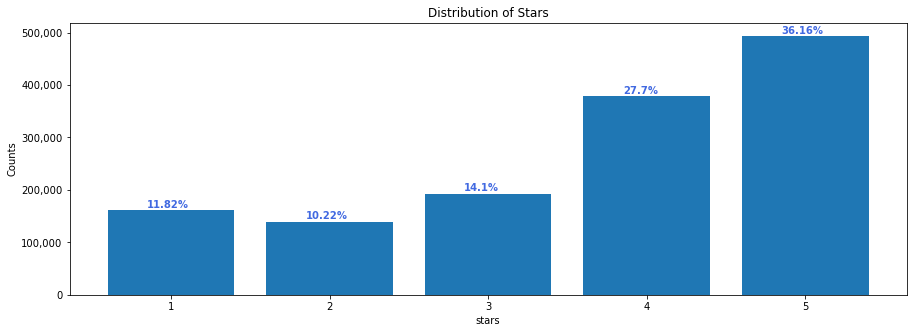

In [15]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y.value_counts().sort_index()):
    axes.text(i-0.15, j + 5000, str(round(j/X.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Our distribution is left skewed. However, we do have a reasonable distribution across all the possible number of ratings.

### Checking Correlation of Numeric Columns with Rating

In [16]:
def correlation_coeff(X, y):
    
    correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])
    
    for column in X.columns:
        corr_coef, p_value = stats.pearsonr(X[column], y)
        correlation_df = correlation_df.append({'Variable': column,
                                                'Correlation Coefficient': corr_coef,
                                                'p-value': p_value}, ignore_index=True)
        correlation_df.sort_values(by='p-value', ascending=False, inplace=True)
    
    return correlation_df

In [17]:
correlation_coeff(X.drop('text', axis=1), y)

,Variable,Correlation Coefficient,p-value
0,Day,0.000464,5.878830e-01
1,Minute,-0.000980,2.524647e-01
2,longitude,0.001961,2.198227e-02
3,GoodForKids,0.002975,5.091648e-04
4,OutdoorSeating,-0.004986,5.697669e-09
5,Salad,0.005149,1.792507e-09
6,Month,-0.005621,5.155104e-11
7,latitude,0.006700,4.961500e-15
8,WiFi_no,0.008080,3.728531e-21
9,RestaurantsAttire_dressy,0.009331,1.134290e-27


### Checking for Multicollinearity

In [18]:
def corr_matrix_heatmap(X):
    plt.figure(figsize=(20,15))
    corr_matrix=X.corr()
    mask = np.triu(np.ones_like(corr_matrix))

    sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
    plt.show()

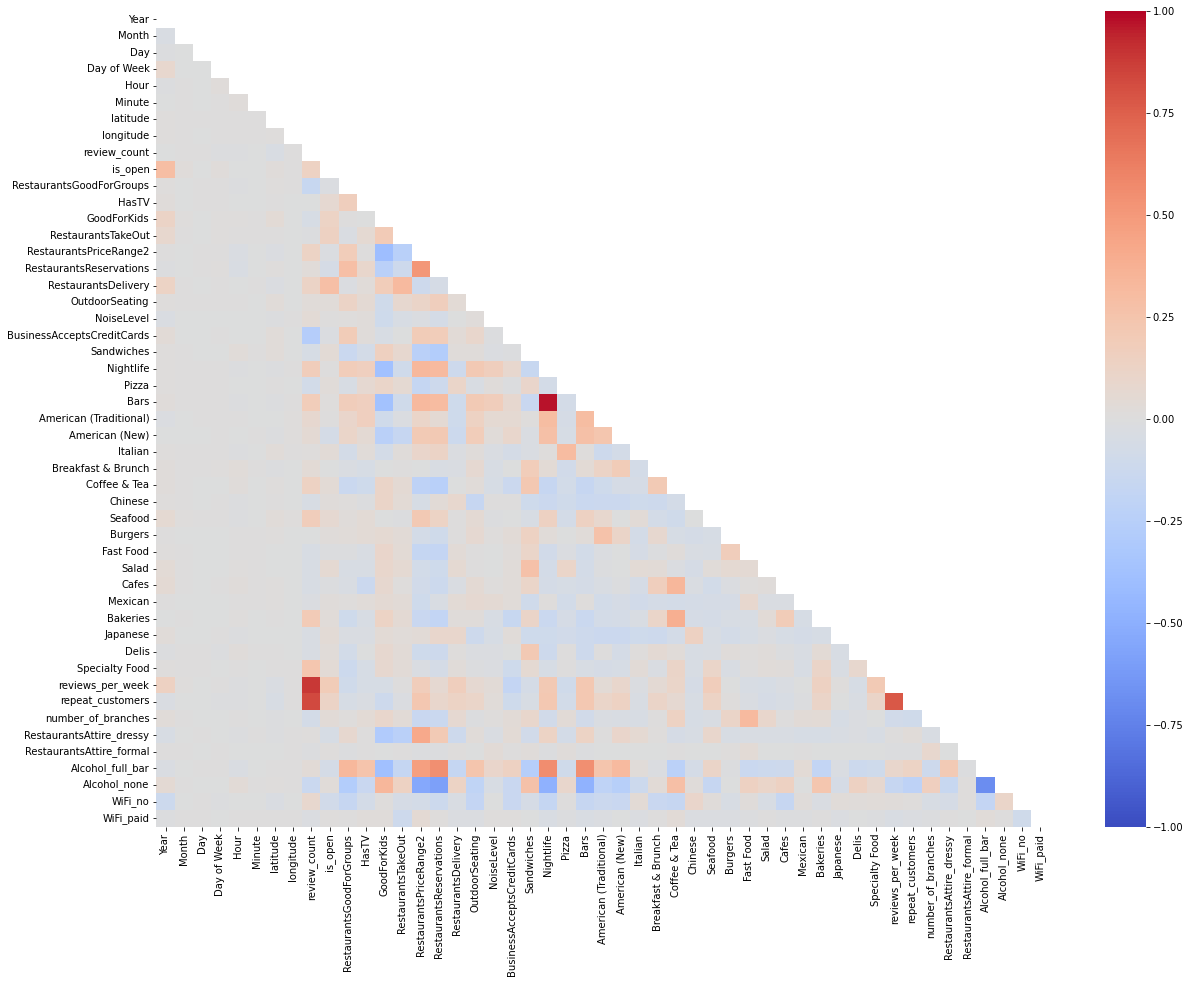

In [19]:
corr_matrix_heatmap(X)

In [20]:
print(f"{stats.pearsonr(X['Bars'], X['Nightlife'])}")
print(f" Correlation of Bars with Stars {stats.pearsonr(X['Bars'], y)}")
print(f" Correlation of Nightlife with Stars {stats.pearsonr(X['Nightlife'], y)}")


(0.975626543772975, 0.0)
 Correlation of Bars with Stars (-0.01024077266579442, 5.470572185952224e-33)
 Correlation of Nightlife with Stars (-0.015227889131218588, 8.268286162727899e-71)


In [21]:
X.drop(['Nightlife', 'review_count'], axis=1, inplace=True)

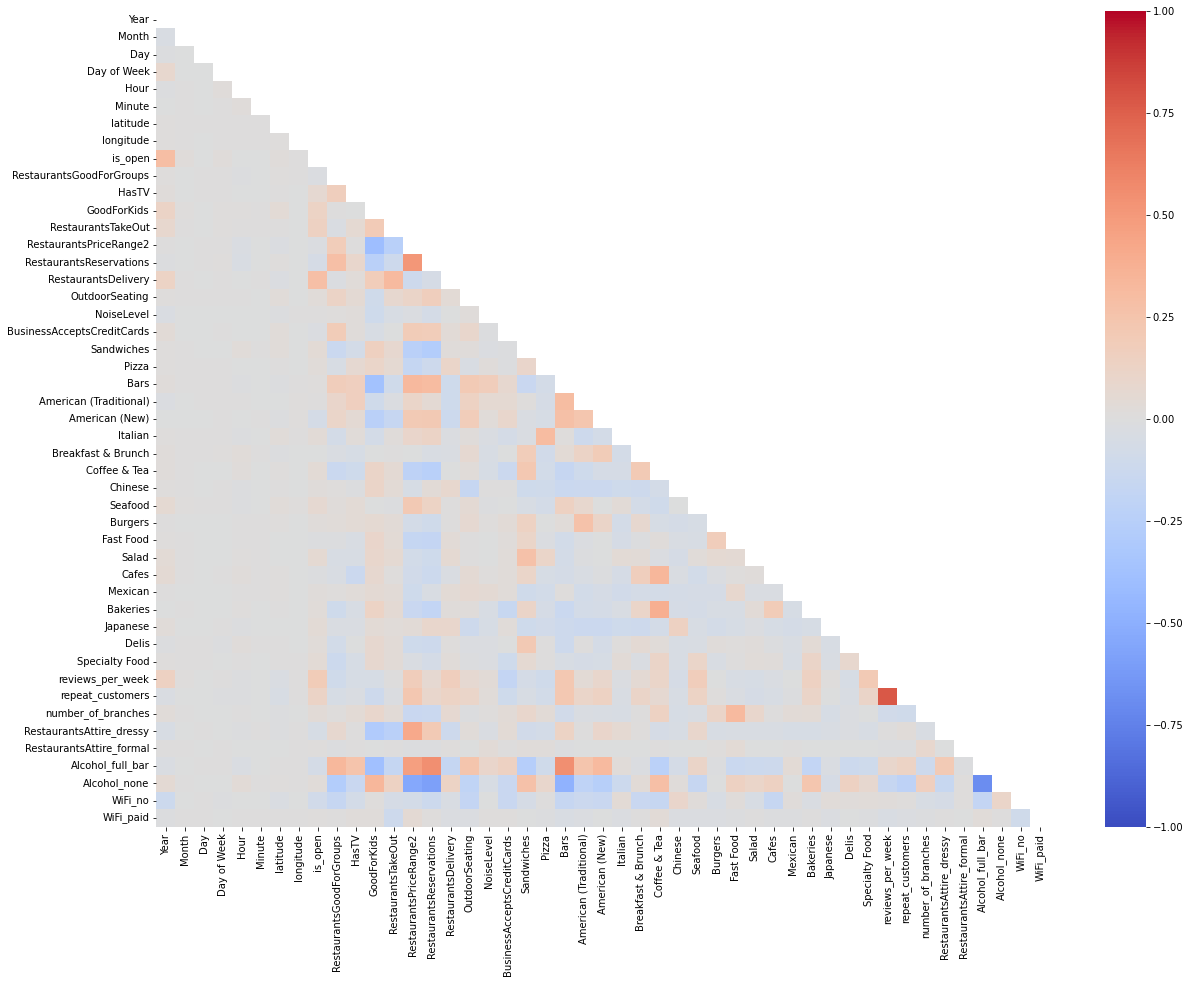

In [22]:
corr_matrix_heatmap(X)

In [23]:
stats.pearsonr(X['reviews_per_week'], X['repeat_customers'])

(0.7803776845662715, 0.0)

### Sampling the Data

Due to the large dataset (1.3 million reviews) which includes text data, and computing hardware limitations, we will subsample our dataset so that the dataset is more manageable more model training and evaluation. We will use the `resample` method from Scikit-Learn, sampling without replacement, and stratifying based on y. For this project, we will utilize around 13,000 reviews (~1% of the original dataset).

In [24]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [25]:
print(f'X_sampled shape: {X_sampled.shape}')
print(f'y_sampled shape: {y_sampled.shape}')

X_sampled shape: (13648, 48)
y_sampled shape: (13648,)


Our sampled dataset has 13,648 rows and 50 columns. Let's take a look at the distribution of our dependent variable in this sample.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_762/1967618503.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


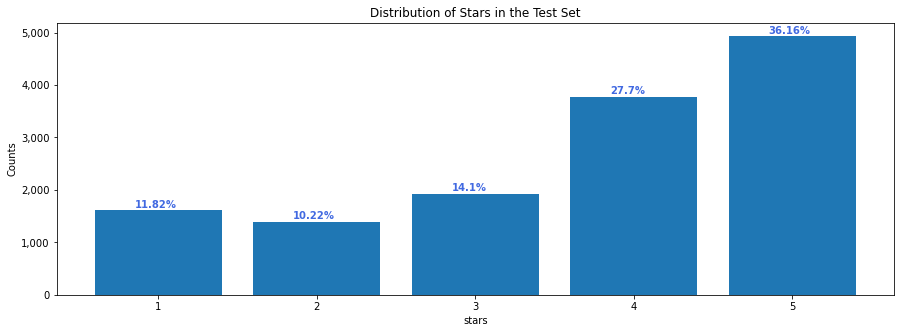

In [26]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_sampled.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_sampled.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

The stratification worked as intended, since our dependent variable distribution in this sample is very similar to its distribution in the overall dataset.

In [27]:
X_sampled.columns

Index(['Year', 'Month', 'Day', 'Day of Week', 'Hour', 'Minute', 'latitude',
       'longitude', 'is_open', 'RestaurantsGoodForGroups', 'HasTV',
       'GoodForKids', 'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'RestaurantsReservations', 'RestaurantsDelivery', 'OutdoorSeating',
       'NoiseLevel', 'BusinessAcceptsCreditCards', 'Sandwiches', 'Pizza',
       'Bars', 'American (Traditional)', 'American (New)', 'Italian',
       'Breakfast & Brunch', 'Coffee & Tea', 'Chinese', 'Seafood', 'Burgers',
       'Fast Food', 'Salad', 'Cafes', 'Mexican', 'Bakeries', 'Japanese',
       'Delis', 'Specialty Food', 'reviews_per_week', 'repeat_customers',
       'number_of_branches', 'RestaurantsAttire_dressy',
       'RestaurantsAttire_formal', 'Alcohol_full_bar', 'Alcohol_none',
       'WiFi_no', 'WiFi_paid', 'text'],
      dtype='object')

## Modelling Setup

### Defining Train and Test Sets

We begin model setup by defining our train and test sets. Note that since we have a relatively smaller dataset to work with (13k rows), we should make sure to leave enough samples in our test set to avoid overfitting to the train set. Hence we will opt for an 80% train - 20% test split.

In [28]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)

print(f'Shape of X_train: {X_train.shape}. Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shape of y_test: {y_test.shape}')

Shape of X_train: (10918, 48). Shaper of y_train: (10918,)
Shape of X_test: (2730, 48). Shaper of y_test: (2730,)


Let's visualize the distributions of our dependent variable from both train and test sets, to ensure we have similar distributions to our original dataset.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_762/825166854.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


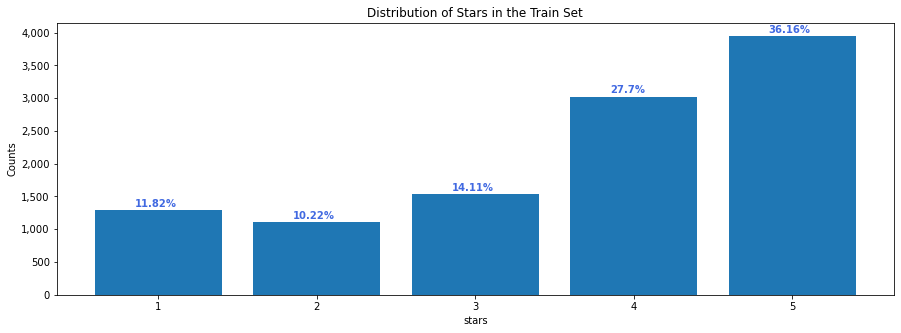

In [29]:
plt.figure(figsize=(15,5))
plt.bar(y_train.value_counts().sort_index().index.astype('str'),
        y_train.value_counts().sort_index())
plt.title('Distribution of Stars in the Train Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_train.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_train.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_762/2988498762.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


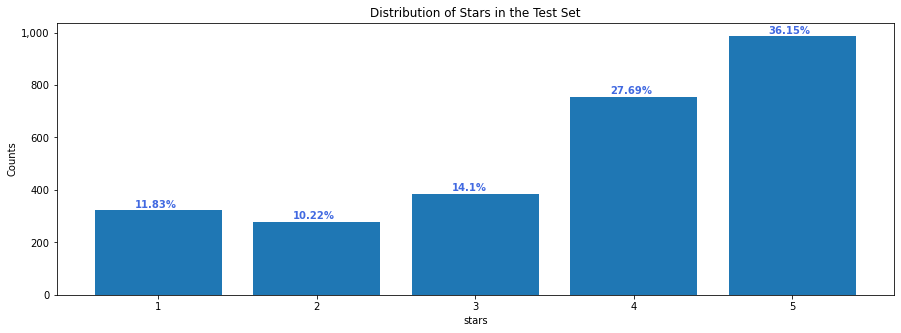

In [30]:
plt.figure(figsize=(15,5))
plt.bar(y_test.value_counts().sort_index().index.astype('str'),
        y_test.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_test.value_counts().sort_index()):
    axes.text(i-0.15, j + 10, str(round(j/X_test.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

We see no major difference between in the dependent variable in both train and test sets when compared to the original dataset. 

### Custom Scoring Functions

Some regression models such as linear regression can make predictions which are lower or greater than the values present in the dataset. Since we know our ratings cannot be below 1 stars nor can they be greater than 5 stars, we need to define a custom function called `bound_predict` that bounds all predictions to within the allowed range. In addition, we need to define a custom scorer function to ensure that Scikit-Learn models such as `cross_validate` and `GridSearchCV` will apply the `bound_predict` method to each model's predictions before calculating the appropriate score. We will pick the model with the best mean absolute error, but we will also monitor the $R^{2}$ score as well to evaluate the quality of the model's fit.

In [31]:
def bound_predict(y_pred):
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

In [32]:
def custom_mae_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Defining Pipeline and Word Encoding Transformers

In [33]:
numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
numeric_columns

['Year',
 'Month',
 'Day',
 'Day of Week',
 'Hour',
 'Minute',
 'latitude',
 'longitude',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'NoiseLevel',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'reviews_per_week',
 'repeat_customers',
 'number_of_branches',
 'RestaurantsAttire_dressy',
 'RestaurantsAttire_formal',
 'Alcohol_full_bar',
 'Alcohol_none',
 'WiFi_no',
 'WiFi_paid']

In [34]:
categorical_columns = X_train.drop('text', axis=1).dtypes[df.dtypes == 'object'].index.to_list()
categorical_columns

[]

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
ENGLISH_STOP_WORDS = stopwords.words('english')

def tokenizer_prep(sentence):
    # remove punctuation and set to lower case
#     english_stop_words = stopwords.words('english')
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    return listofwords


def tokenizer_stemming(sentence):
    stemmer = PorterStemmer()
    listofwords = tokenizer_prep(sentence) 
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

def tokenizer_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    listofwords = tokenizer_prep(sentence) 
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lematized words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words


In [37]:
tokenizer_stemming('This is awesome \n dsdd')

['awesom', '\n', 'dsdd']

In [38]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False)

In [39]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

def sent2vec_col_trans(col):
    sentence_embedding = col.apply(sentence2vec)
    return np.array(sentence_embedding.tolist())

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

In [41]:
def define_col_trans(input_text, vectorizer):
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns),
        (input_text, vectorizer, 'text')
    ])
    
    return col_trans

In [42]:
def convert_to_array(sparse_matrix):
#     return sparse_matrix.toarray()
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

In [43]:
bow_ct = define_col_trans('bow_ct', CountVectorizer(stop_words=ENGLISH_STOP_WORDS, min_df=25))
bow_stem_ct = define_col_trans('bow_stem_ct', CountVectorizer(tokenizer=tokenizer_stemming, min_df=25))
bow_lem_ct = define_col_trans('bow_lem_ct', CountVectorizer(tokenizer=tokenizer_lemmatizer, min_df=25))
tfidf_ct = define_col_trans('tfidf_ct', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, min_df=25))
tfidf_stem_ct = define_col_trans('tfidf_stem_ct', TfidfVectorizer(tokenizer=tokenizer_stemming, min_df=25))
tfidf_lem_ct = define_col_trans('tfidf_lem_ct', TfidfVectorizer(tokenizer=tokenizer_lemmatizer, min_df=25))
sent2vec = define_col_trans('sent2vec', FunctionTransformer(sent2vec_col_trans))

vectorizer_list = [bow_ct, bow_stem_ct, bow_lem_ct, tfidf_ct, tfidf_stem_ct, tfidf_lem_ct, sent2vec]

In [44]:
%%time

print(f'Shape of X_train using bag of words without stemming or lemmatization: {bow_ct.fit_transform(X_train).shape}')
print(f'Shape of X_train using bag of words with stemming: {bow_stem_ct.fit_transform(X_train).shape}')
print(f'Shape of X_train using bag of words with lemmatization: {bow_lem_ct.fit_transform(X_train).shape}')
print(f'Shape of X_train using word embeddings: {sent2vec.fit_transform(X_train).shape}')


Shape of X_train using bag of words without stemming or lemmatization: (10918, 2676)
Shape of X_train using bag of words with stemming: (10918, 2282)
Shape of X_train using bag of words with lemmatization: (10918, 2517)
Shape of X_train using word embeddings: (10918, 347)
CPU times: user 23 s, sys: 224 ms, total: 23.2 s
Wall time: 23.3 s


In [45]:
temp_df = bow_ct.fit_transform(X_train)
temp_df.shape

(10918, 2676)

In [46]:
temp_df = sent2vec.fit_transform(X_train)
temp_df.shape

(10918, 347)

### Dummy Model

In [47]:
# dummy_reg = DummyRegressor(strategy="mean")
# dummy_reg.fit(X_test_scaled_1a, y_test)

In [48]:
# prediction = dummy_reg.predict(X_test_scaled_1a)
# mean_absolute_error(y_test, prediction)

In [49]:
# custom_mae_scorer_func(y_test, prediction)

## Model Evaluation

In [63]:
def model_results(estimator, X_train, y_train, X_test, y_test):
    fitted_values = bound_predict(estimator.predict(X_train))
    print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
    print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

    print('\n')

    fitted_values = bound_predict(estimator.predict(X_test))
    print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
    print(f'R^2 on test set: {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

### Linear Regression

In [50]:
%%time

pipeline = Pipeline([
    ('col_trans', bow_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

CPU times: user 1.32 s, sys: 187 ms, total: 1.51 s
Wall time: 1.51 s


In [51]:
X_train_prepared.shape

(10918, 2676)

In [52]:
pipeline.get_params()['col_trans'].get_feature_names()

/Users/allistaircota/opt/anaconda3/envs/yelp_capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['Year',
 'Month',
 'Day',
 'Day of Week',
 'Hour',
 'Minute',
 'latitude',
 'longitude',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'NoiseLevel',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'reviews_per_week',
 'repeat_customers',
 'number_of_branches',
 'RestaurantsAttire_dressy',
 'RestaurantsAttire_formal',
 'Alcohol_full_bar',
 'Alcohol_none',
 'WiFi_no',
 'WiFi_paid',
 'bow_ct__00',
 'bow_ct__10',
 'bow_ct__100',
 'bow_ct__11',
 'bow_ct__12',
 'bow_ct__13',
 'bow_ct__14',
 'bow_ct__15',
 'bow_ct__16',
 'bow_ct__17',
 'bow_ct__18',
 'bow_ct__19',
 'bow_ct__1st',
 'bow_ct__20',
 'bow_ct

In [53]:
X_test_prepared.shape

(2730, 2676)

#### L2 Regularization

In [54]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100, 1000]:
    #alpha = 10**power
    
   
    cv_scores = cross_validate(Ridge(alpha=alpha), X_train_prepared, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 7min 52s, sys: 46.7 s, total: 8min 39s
Wall time: 54.6 s


,alpha,MAE,R-squared
0,0.0001,0.770028,0.451630
1,0.0010,0.769980,0.451728
2,0.0100,0.769258,0.453285
3,0.1000,0.764137,0.462217
4,1.0000,0.739850,0.504307
5,5.0000,0.721415,0.541021
6,10.0000,0.724279,0.543818
7,15.0000,0.731129,0.539263
8,20.0000,0.738702,0.532806
9,50.0000,0.779991,0.492091


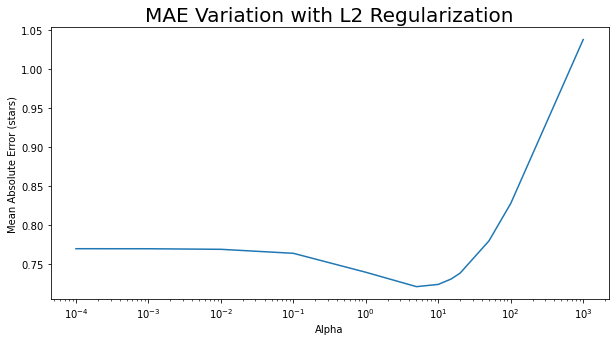

In [55]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'])
plt.title('MAE Variation with L2 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.show()

#### L1 Regularization

In [56]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for alpha in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100]:
       
    cv_scores = cross_validate(Lasso(alpha=alpha), X_train_prepared, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 5min 34s, sys: 49.5 s, total: 6min 24s
Wall time: 1min 44s


,alpha,MAE,R-squared
0,0.00001,0.761776,0.465541
1,0.00010,0.725275,0.527103
2,0.00100,0.745737,0.522499
3,0.01000,0.986614,0.235944
4,0.05000,1.154610,0.000997
5,0.10000,1.155397,-0.000224
6,1.00000,1.155397,-0.000224
7,10.00000,1.155397,-0.000224
8,100.00000,1.155397,-0.000224


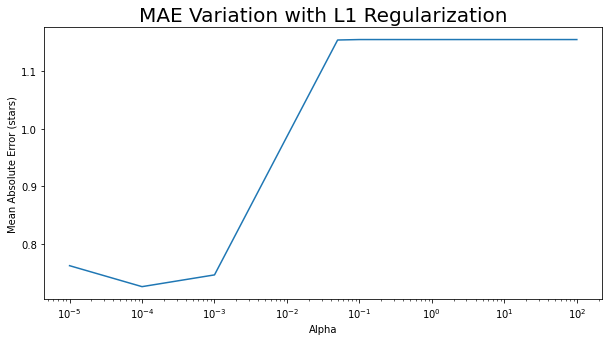

In [57]:
plt.figure(figsize=(10,5))
plt.plot(scores['alpha'], scores['MAE'])
plt.title('MAE Variation with L1 Regularization', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (stars)')
plt.xscale('log')
plt.show()

#### Pipeline and Model Optimization Using GridSearchCV

In [68]:
linreg_pipeline = Pipeline([
    ('col_trans', bow_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge())
])


param_grid = [
                {
                    'model': [LinearRegression()],
                    'col_trans': vectorizer_list
                },
                {
                    'model': [Ridge()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [1, 5, 10]
                },
                {
                    'model': [Lasso()],
                    'col_trans': vectorizer_list,
                    'model__alpha': [0.00001, 0.0001, 0.001]
                }] 


linreg_grid_search = GridSearchCV(linreg_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4, n_jobs=-2)

In [69]:
%%time
linreg_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwic...
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('bow_ct',

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwic...
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('bow_ct',
                                 CountVectorizer(min_df=25,
 

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwic...
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('bow_ct',
                                 CountVectorizer(min_df=25,
 

[CV 3/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwic...
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('bow_ct',
                                 CountVectorizer(min_df=25,
 

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 4/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwic...
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('bow_ct',
                                 CountVectorizer(min_df=25,
 

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 1/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

[CV 2/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
                                ('tfidf_lem_ct',
                                 TfidfVectorizer(min_df=25,
                                                 tokenizer=<f

[CV 5/5] END col_trans=ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'NoiseLevel', 'BusinessAcceptsCreditCards',
                                  'Sandwiches', 'Pizza', 'Bars',
                                  'American (Traditional)', 'American (New)',
                                  'Italian', 'Breakfast & Brunch',
                                  'Coffee & Tea', 'Chinese', 'Seafood',
                                  'Burgers', ...]),
       

CPU times: user 59.2 s, sys: 5.99 s, total: 1min 5s
Wall time: 9min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [70]:
linreg_grid_search.best_params_

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                   'Minute', 'latitude', 'longitude', 'is_open',
                                   'RestaurantsGoodForGroups', 'HasTV',
                                   'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'NoiseLevel', 'BusinessAcceptsCreditCards',
                                   'Sandwic...
                                   'Italian', 'Breakfast & Brunch',
                                   'Coffee & Tea', 'Chinese', 'Seafood',
                                   'Burgers', ...]),
                                 ('tfidf_ct',
                                  TfidfVectorizer(min_d

The best pipeline returned by the Linear Regression Grid Search was a TF-IDF Vectorizer without stemming nor lemmatization with a Lasso Regression model with an alpha value of 0.0005.

In [71]:
type(linreg_grid_search.cv_results_['params'][0]['model']) == LinearRegression

True

In [75]:
linreg_grid_search.cv_results_['params'][0]['col_trans'].get_params()['transformers'][1][0]

'bow_ct'

In [111]:
linreg_grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_col_trans', 'param_model', 'param_model__alpha', 'params', 'split0_test_custom_mae_scorer', 'split1_test_custom_mae_scorer', 'split2_test_custom_mae_scorer', 'split3_test_custom_mae_scorer', 'split4_test_custom_mae_scorer', 'mean_test_custom_mae_scorer', 'std_test_custom_mae_scorer', 'rank_test_custom_mae_scorer', 'split0_test_custom_r2_scorer', 'split1_test_custom_r2_scorer', 'split2_test_custom_r2_scorer', 'split3_test_custom_r2_scorer', 'split4_test_custom_r2_scorer', 'mean_test_custom_r2_scorer', 'std_test_custom_r2_scorer', 'rank_test_custom_r2_scorer'])

In [118]:
linreg_grid_search.cv_results_['mean_test_custom_mae_scorer']

array([-0.75039233, -0.75443946, -0.75217708, -0.66848244, -0.67571587,
       -0.67946519, -0.7196864 , -0.72964231, -0.71551384, -0.80632288,
       -0.74101765, -0.7340573 , -0.82814843, -0.73690077, -0.73135075,
       -0.82644643, -0.65291945, -0.64030023, -0.75829842, -0.66655571,
       -0.66035606, -0.78522091, -0.66773341, -0.65945786, -0.78754386,
       -0.72105351, -0.73155249, -0.80054235, -0.71658714, -0.71006256,
       -0.71658714, -0.73035682, -0.72829869, -0.73035682, -0.72456135,
       -0.72373918, -0.72456135, -0.63850627, -0.63766529, -0.63850627,
       -0.65730315, -0.65770902, -0.65730315, -0.6553502 , -0.65539389,
       -0.6553502 , -0.72099501, -0.73110545, -0.72099501])

In [76]:
temp_df = pd.DataFrame(columns=['Regularization', 'Vectorizer', 'Alpha', 'MAE', 'R2'])

for item in linreg_grid_search.cv_results_['params']:
    i = linreg_grid_search.cv_results_['params'].index(item)
    #model_type = type(item['model'])
    if type(item['model']) == Ridge:
        reg_type = 'L2 Regularization'
        
    elif type(item['model']) == Lasso:
        reg_type = 'L1 Regularization'
    
    else:
        reg_type = 'No Regularization'
    
    vectorizer = item['col_trans'].get_params()['transformers'][1][0]
    
    if reg_type == 'No Regularization':
        alpha = 0
    
    else:
        alpha = item['model__alpha']
    
    temp_df = temp_df.append({'Regularization': reg_type,
                              'Vectorizer': vectorizer,
                              'Alpha': alpha,
                              'MAE': -linreg_grid_search.cv_results_['mean_test_custom_mae_scorer'][i],
                              'R2': linreg_grid_search.cv_results_['mean_test_custom_r2_scorer'][i]},
                             ignore_index=True)
    
temp_df
        

,Regularization,Vectorizer,Alpha,MAE,R2
0,No Regularization,bow_ct,0,0.759384,0.472342
1,No Regularization,bow_stem_ct,0,0.752812,0.482623
2,No Regularization,bow_lem_ct,0,0.755114,0.480415
3,No Regularization,tfidf_ct,0,0.676106,0.572862
4,No Regularization,tfidf_stem_ct,0,0.672336,0.576237
5,No Regularization,tfidf_lem_ct,0,0.676435,0.572292
6,No Regularization,sent2vec,0,0.723344,0.544381
7,L2 Regularization,bow_ct,1,0.740650,0.505370
8,L2 Regularization,bow_ct,5,0.725592,0.535353
9,L2 Regularization,bow_ct,10,0.727249,0.538866


In [77]:
temp_df[temp_df['Regularization'].isin(['No Regularization', 'L2 Regularization'])]

,Regularization,Vectorizer,Alpha,MAE,R2
0,No Regularization,bow_ct,0,0.759384,0.472342
1,No Regularization,bow_stem_ct,0,0.752812,0.482623
2,No Regularization,bow_lem_ct,0,0.755114,0.480415
3,No Regularization,tfidf_ct,0,0.676106,0.572862
4,No Regularization,tfidf_stem_ct,0,0.672336,0.576237
5,No Regularization,tfidf_lem_ct,0,0.676435,0.572292
6,No Regularization,sent2vec,0,0.723344,0.544381
7,L2 Regularization,bow_ct,1,0.740650,0.505370
8,L2 Regularization,bow_ct,5,0.725592,0.535353
9,L2 Regularization,bow_ct,10,0.727249,0.538866


In [138]:
vectorizer_dict = {'bow_ct': {'descriptor': 'Bag of Words', 'color': 'blue'},
                   'bow_stem_ct': {'descriptor': 'Bag of Words with Stemming', 'color': 'cornflowerblue'},
                   'bow_lem_ct': {'descriptor': 'Bag of Words with Lemmatization', 'color': 'lightsteelblue'},
                   'tfidf_ct': {'descriptor': 'TF-IDF', 'color': 'red'},
                   'tfidf_stem_ct': {'descriptor': 'TF-IDF with Stemming', 'color': 'lightsalmon'},
                   'tfidf_lem_ct': {'descriptor': 'TF-IDF with Lemmatization', 'color': 'peachpuff'},
                   'sent2vec': {'descriptor': 'Word Embeddings','color': 'orange'}}

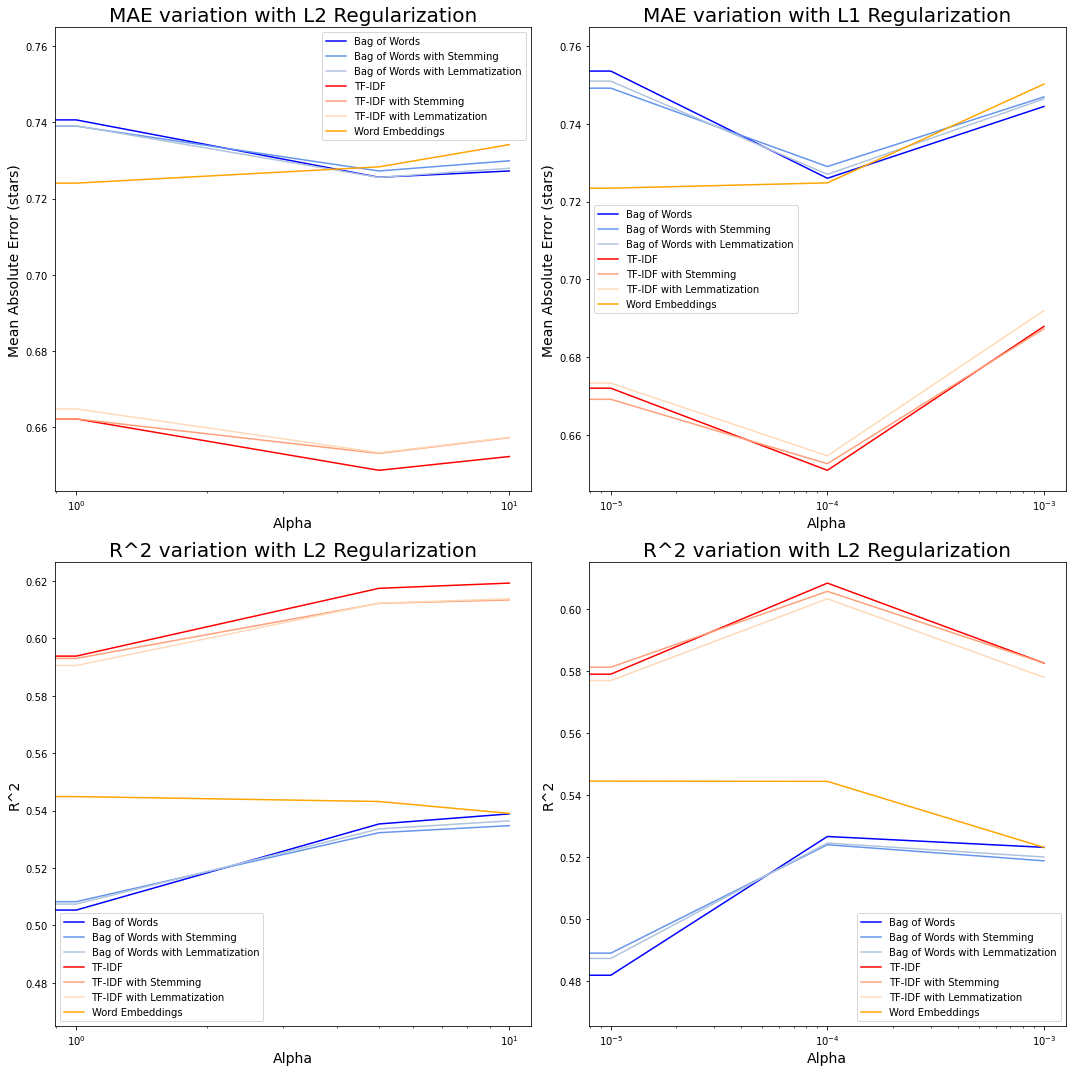

In [78]:
plt.subplots(2, 2, figsize=(15,15))

l2_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L2 Regularization'])]

plt.subplot(2, 2, 1)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()
    
plt.subplot(2, 2, 3)
for vectorizer in l2_df['Vectorizer'].unique():
    vect_df = l2_df[l2_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()
    
plt.subplot(2, 2, 2)
l1_df = temp_df[temp_df['Regularization'].isin(['No Regularization', 'L1 Regularization'])]

for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('MAE variation with L1 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()

plt.subplot(2, 2, 4)
for vectorizer in l1_df['Vectorizer'].unique():
    vect_df = l1_df[l1_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['Alpha'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    plt.xscale('log')
    plt.title('R^2 variation with L2 Regularization', fontsize=20)
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()


plt.tight_layout()
plt.show()

Now that we have tuned our pipeline's column transformer and model hyperparameters, we can now train it on the full training set and evaluate it on the test set.

In [59]:
# Save the best pipeline to a variable
#best_linreg_pipeline = linreg_grid_search.best_estimator_
#
best_linreg_pipeline = joblib.load('best_linreg_pipeline.pkl') 
best_linreg_pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
       

In [60]:
%%time

# Fit the model
best_linreg_pipeline.fit(X_train, y_train)

CPU times: user 7.79 s, sys: 732 ms, total: 8.52 s
Wall time: 1.96 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
       

In [64]:
model_results(best_linreg_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.53 stars
R^2 on train set 0.74


MAE on test set: 0.66 stars
R^2 on test set: 0.61


Our mean absolute error on the train set is 0.59 stars, while the test set has a mean absolute error of 0.63 stars. Our $R^{2}$ values on the train and test sets are 0.68 and 0.63 respectively.

#### Most Important Features

In [65]:
coef_df = pd.DataFrame({'feature': best_linreg_pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': best_linreg_pipeline.named_steps['model'].coef_}).\
                        sort_values("coefficient", ascending=False)
coef_df.head()

,feature,coefficient
141,tfidf_ct__amazing,1.388158
282,tfidf_ct__best,1.266147
1091,tfidf_ct__great,1.264459
218,tfidf_ct__awesome,1.080323
698,tfidf_ct__delicious,0.972452


In [66]:
review_coef_df = coef_df[coef_df['feature'].str.contains('tfidf_ct__')]
review_coef_df.head()

,feature,coefficient
141,tfidf_ct__amazing,1.388158
282,tfidf_ct__best,1.266147
1091,tfidf_ct__great,1.264459
218,tfidf_ct__awesome,1.080323
698,tfidf_ct__delicious,0.972452


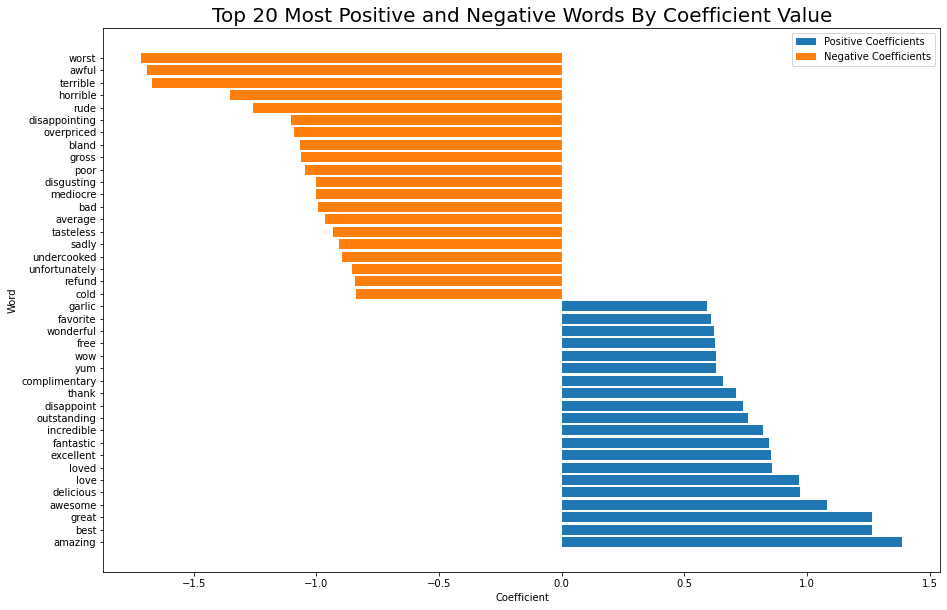

In [67]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ct__', '').head(20),
         review_coef_df.head(20)["coefficient"], label='Positive Coefficients')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ct__', '').tail(20),
         review_coef_df.tail(20)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

In [71]:
remaining_coef_df = coef_df[coef_df['feature'].str.contains('numeric__')]
remaining_coef_df.head()

,feature,coefficient
38,numeric__reviews_per_week,0.297318
39,numeric__repeat_customers,0.109252
7,numeric__longitude,0.107246
0,numeric__Year,0.068382
8,numeric__is_open,0.064017


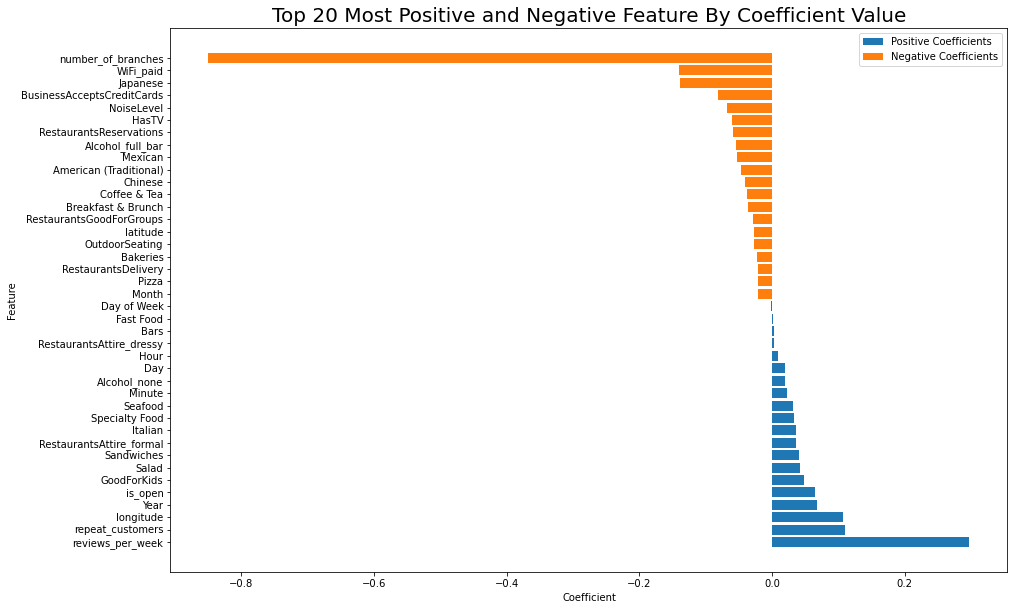

In [72]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Feature By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__', '').head(20),
         remaining_coef_df.head(20)["coefficient"], label='Positive Coefficients')
plt.barh(remaining_coef_df['feature'].str.replace('numeric__', '').tail(20),
         remaining_coef_df.tail(20)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

#### Saving the model

In [87]:
joblib.dump(best_linreg_pipeline, 'best_linreg_pipeline.pkl') 

['best_linreg_pipeline.pkl']

#### N-grams

In [89]:
tfidf_ngram_ct = define_col_trans('tfidf_ngram_ct',
                                   TfidfVectorizer(max_features=10000, ngram_range=(2,3),
                                                   stop_words=ENGLISH_STOP_WORDS))

pipeline = Pipeline([
    ('col_trans', tfidf_ngram_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

In [90]:
%%time
X_train_prepared = pipeline.fit_transform(X_train)
X_train_prepared.shape

CPU times: user 5.27 s, sys: 546 ms, total: 5.82 s
Wall time: 5.82 s


(10918, 10047)

In [91]:
pipeline.named_steps['col_trans'].get_feature_names_out()

array(['numeric__Year', 'numeric__Month', 'numeric__Day', ...,
       'tfidf_ngram_ct__yummy food', 'tfidf_ngram_ct__yummy well',
       'tfidf_ngram_ct__zero stars'], dtype=object)

In [92]:
ridge_reg = Ridge(alpha=5)

In [93]:
%%time

ridge_reg.fit(X_train_prepared, y_train)

CPU times: user 1min 54s, sys: 5 s, total: 1min 59s
Wall time: 15.4 s


Ridge(alpha=5)

In [94]:
X_test_prepared = pipeline.transform(X_test)

In [109]:
model_results(ridge_reg, X_train_prepared, y_train, X_test_prepared, y_test)

MAE on train set: 0.53 stars
R^2 on train set 0.75


MAE on test set: 0.79 stars
R^2 on test set 0.46


In [96]:
ngram_coef_df = pd.DataFrame({'feature': pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': ridge_reg.coef_}).\
                        sort_values("coefficient", ascending=False)
ngram_coef_df.head()

,feature,coefficient
7189,tfidf_ngram_ct__really good,1.034627
4459,tfidf_ngram_ct__highly recommend,1.019150
916,tfidf_ngram_ct__best ever,1.018427
5198,tfidf_ngram_ct__love place,1.009203
6019,tfidf_ngram_ct__one best,0.902787


In [97]:
review_coef_df = ngram_coef_df[ngram_coef_df['feature'].str.contains('tfidf_ngram_ct__')]
review_coef_df.head()

,feature,coefficient
7189,tfidf_ngram_ct__really good,1.034627
4459,tfidf_ngram_ct__highly recommend,1.019150
916,tfidf_ngram_ct__best ever,1.018427
5198,tfidf_ngram_ct__love place,1.009203
6019,tfidf_ngram_ct__one best,0.902787


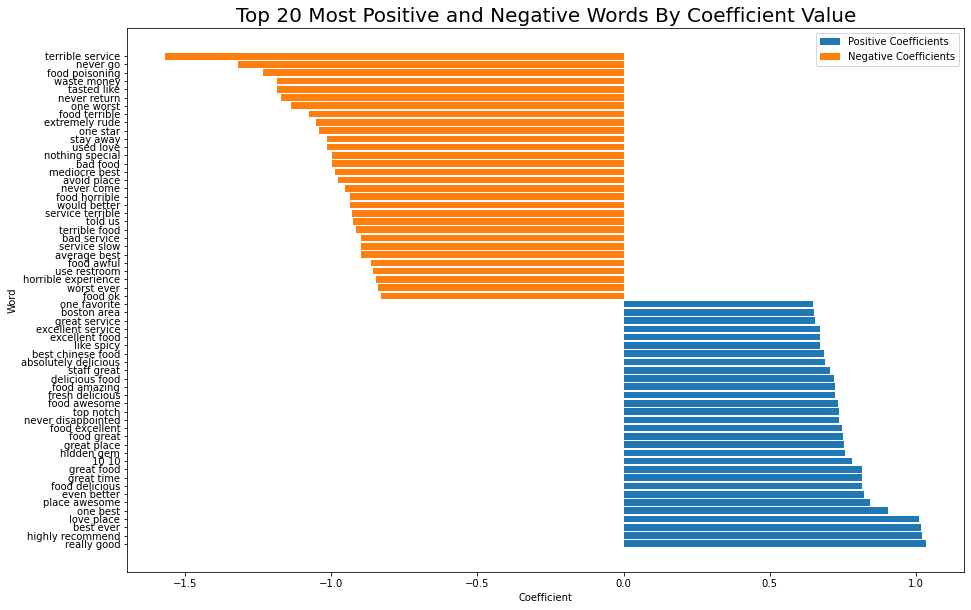

In [98]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ngram_ct__', '').head(30),
         review_coef_df.head(30)["coefficient"], label='Positive Coefficients')
plt.barh(review_coef_df['feature'].str.replace('tfidf_ngram_ct__', '').tail(30),
         review_coef_df.tail(30)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

In [74]:
ext_stopwords = ['amazing', 'best', 'great', 'awesome', 'love', 'loved',
                 'excellent', 'fantastic', 'incredible', 'outstanding', 'disappoint',
                'wow', 'wonderful', 'unfortunately', 'sadly', 'average', 'bad', 'mediocre',
                'poor', 'disappointing', 'horrible', 'terrible', 'awful', 'worst'] + ENGLISH_STOP_WORDS

In [77]:
tfidf_ext_stopwords = define_col_trans('tfidf_ngram_ct',
                                   TfidfVectorizer(max_features=10000, ngram_range=(1,2),
                                                   stop_words=ext_stopwords))

pipeline = Pipeline([
    ('col_trans', tfidf_ext_stopwords),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

In [78]:
%%time
X_train_prepared = pipeline.fit_transform(X_train)
X_train_prepared.shape

CPU times: user 3.4 s, sys: 597 ms, total: 4 s
Wall time: 4.23 s


(10918, 10047)

In [79]:
pipeline.named_steps['col_trans'].get_feature_names_out()

array(['numeric__Year', 'numeric__Month', 'numeric__Day', ...,
       'tfidf_ngram_ct__ziti', 'tfidf_ngram_ct__zone',
       'tfidf_ngram_ct__zucchini'], dtype=object)

In [81]:
%%time

ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train_prepared, y_train)

CPU times: user 2min, sys: 5.76 s, total: 2min 6s
Wall time: 17.6 s


Ridge(alpha=5)

In [83]:
X_test_prepared = pipeline.transform(X_test)

model_results(ridge_reg, X_train_prepared, y_train, X_test_prepared, y_test)

MAE on train set: 0.43 stars
R^2 on train set 0.83


MAE on test set: 0.7 stars
R^2 on test set: 0.57


In [84]:
ext_coef_df = pd.DataFrame({'feature': pipeline.named_steps['col_trans'].get_feature_names_out(),
                        'coefficient': ridge_reg.coef_}).\
                        sort_values("coefficient", ascending=False)
ext_coef_df.head()

,feature,coefficient
2256,tfidf_ngram_ct__delicious,1.024848
3830,tfidf_ngram_ct__go wrong,0.821956
2776,tfidf_ngram_ct__even better,0.817101
8827,tfidf_ngram_ct__thank,0.797318
9528,tfidf_ngram_ct__wait go,0.645900


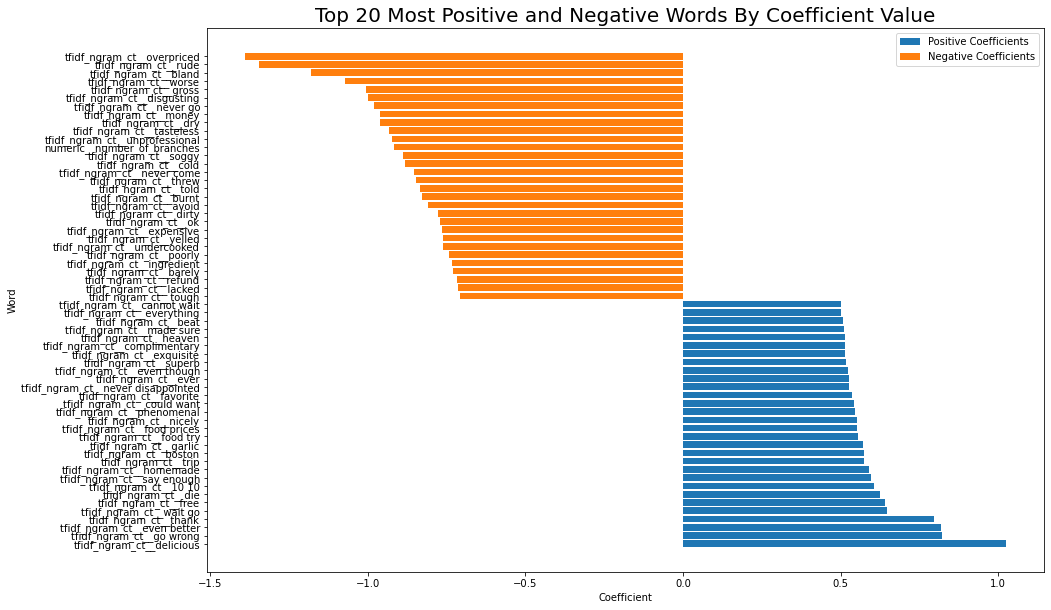

In [85]:
plt.figure(figsize=(15,10))
plt.title('Top 20 Most Positive and Negative Words By Coefficient Value', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.barh(ext_coef_df['feature'].head(30),
         ext_coef_df.head(30)["coefficient"], label='Positive Coefficients')
plt.barh(ext_coef_df['feature'].tail(30),
         ext_coef_df.tail(30)["coefficient"], label='Negative Coefficients')
plt.legend()

plt.show()

### Decision Trees

In [89]:
%%time

pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True))
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

CPU times: user 5.96 s, sys: 220 ms, total: 6.18 s
Wall time: 6.26 s


In [105]:
%%time

scores = pd.DataFrame(columns=['max_depth', 'max_features', 'MAE', 'R-squared'])

for max_depth in [5, 10, 15, 20, 25, 30]:
    
    for max_features in [0.25, 0.5, 0.75, 1.0]:
    #alpha = 10**power
    
   
        cv_scores = cross_validate(DecisionTreeRegressor(max_depth=max_depth,
                                                         min_samples_leaf=2,
                                                         max_features=max_features,
                                                         random_state=0),
                                   X_train_prepared, y_train, cv=5,
                                   scoring=scorer)

        scores = scores.append({'max_depth': max_depth, 'max_features': max_features,
                                        'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                        'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])},
                               ignore_index=True)
    
    
scores

CPU times: user 5min 47s, sys: 12.8 s, total: 6min
Wall time: 6min 2s


,max_depth,max_features,MAE,R-squared
0,5.0,0.25,1.012779,0.167717
1,5.0,0.50,0.991265,0.204533
2,5.0,0.75,0.995537,0.204017
3,5.0,1.00,0.994758,0.201067
4,10.0,0.25,0.947319,0.242194
5,10.0,0.50,0.910799,0.285637
6,10.0,0.75,0.926834,0.262531
7,10.0,1.00,0.918220,0.271354
8,15.0,0.25,0.898371,0.272419
9,15.0,0.50,0.887646,0.274765


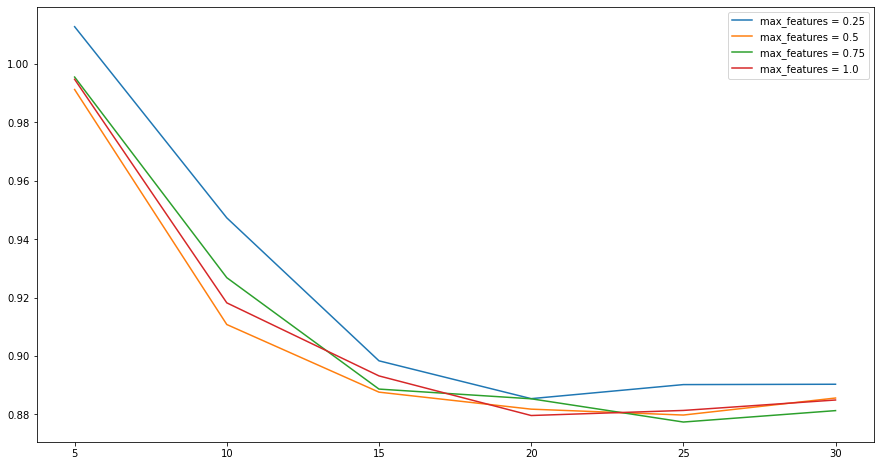

In [112]:
plt.figure(figsize=(15,8))
for max_features in scores['max_features'].unique():
    temp_df = scores[scores['max_features'] == max_features]
    plt.plot(temp_df['max_depth'], temp_df['MAE'], label='max_features = ' + str(max_features))

plt.legend()
plt.plot()
plt.show()

In [109]:
DT_reg = DecisionTreeRegressor(max_depth = 25,
                               max_features = 0.75,
                               min_samples_leaf=6,
                               random_state=0)

In [110]:
%%time

DT_reg.fit(X_train_prepared, y_train)

CPU times: user 5.91 s, sys: 82.8 ms, total: 5.99 s
Wall time: 6.04 s


DecisionTreeRegressor(max_depth=25, max_features=0.75, min_samples_leaf=2,
                      random_state=0)

In [111]:
model_results(DT_reg, X_train_prepared, y_train, X_test_prepared, y_test)

MAE on train set: 0.46 stars
R^2 on train set 0.73


MAE on test set: 0.89 stars
R^2 on test set: 0.19


#### Pipeline and Model Optimization Search

In [127]:
DT_pipeline = Pipeline([
    ('col_trans', bow_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', DecisionTreeRegressor())
])


param_grid = [
                {
                    'model__max_depth': [17, 20, 23],
                    'model__max_features': [0.5, 0.75, 1],
                    'model__min_samples_leaf': [6],
                    'model__random_state': [0],
                    'col_trans': vectorizer_list
                }] 

DT_grid_search = GridSearchCV(DT_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-2)

In [128]:
%%time

DT_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
CPU times: user 1min 18s, sys: 8.47 s, total: 1min 27s
Wall time: 11min 41s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [129]:
DT_grid_search.best_score_

-0.8577664748349643

In [130]:
DT_grid_search.best_params_

{'col_trans': ColumnTransformer(transformers=[('numeric', 'passthrough',
                                  ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                   'Minute', 'latitude', 'longitude', 'is_open',
                                   'RestaurantsGoodForGroups', 'HasTV',
                                   'GoodForKids', 'RestaurantsTakeOut',
                                   'RestaurantsPriceRange2',
                                   'RestaurantsReservations',
                                   'RestaurantsDelivery', 'OutdoorSeating',
                                   'NoiseLevel', 'BusinessAcceptsCreditCards',
                                   'Sandwic...
                                   'Italian', 'Breakfast & Brunch',
                                   'Coffee & Tea', 'Chinese', 'Seafood',
                                   'Burgers', ...]),
                                 ('tfidf_ct',
                                  TfidfVectorizer(min_d

In [145]:
temp_df = pd.DataFrame(columns=['Vectorizer', 'max_depth', 'max_features', 'MAE', 'R2'])

for item in DT_grid_search.cv_results_['params']:
    i = DT_grid_search.cv_results_['params'].index(item)
    
    vectorizer = item['col_trans'].get_params()['transformers'][1][0]
    
    max_depth = item['model__max_depth']
    
    max_features = item['model__max_features']
    
    temp_df = temp_df.append({'Vectorizer': vectorizer,
                              'max_depth': max_depth,
                              'max_features': max_features,
                              'MAE': -DT_grid_search.cv_results_['mean_test_custom_mae_scorer'][i],
                              'R2': DT_grid_search.cv_results_['mean_test_custom_r2_scorer'][i]},
                             ignore_index=True)
    
temp_df.sort_values(by='MAE').head(20)

,Vectorizer,max_depth,max_features,MAE,R2
33,tfidf_ct,23,0.50,0.857766,0.291937
39,tfidf_stem_ct,20,0.50,0.859161,0.297795
34,tfidf_ct,23,0.75,0.859495,0.282448
37,tfidf_stem_ct,17,0.75,0.860944,0.301739
43,tfidf_stem_ct,23,0.75,0.861593,0.274152
27,tfidf_ct,17,0.50,0.861743,0.314945
52,tfidf_lem_ct,23,0.75,0.862798,0.277905
3,bow_ct,20,0.50,0.863019,0.307244
40,tfidf_stem_ct,20,0.75,0.863066,0.287356
16,bow_stem_ct,23,0.75,0.863068,0.280166


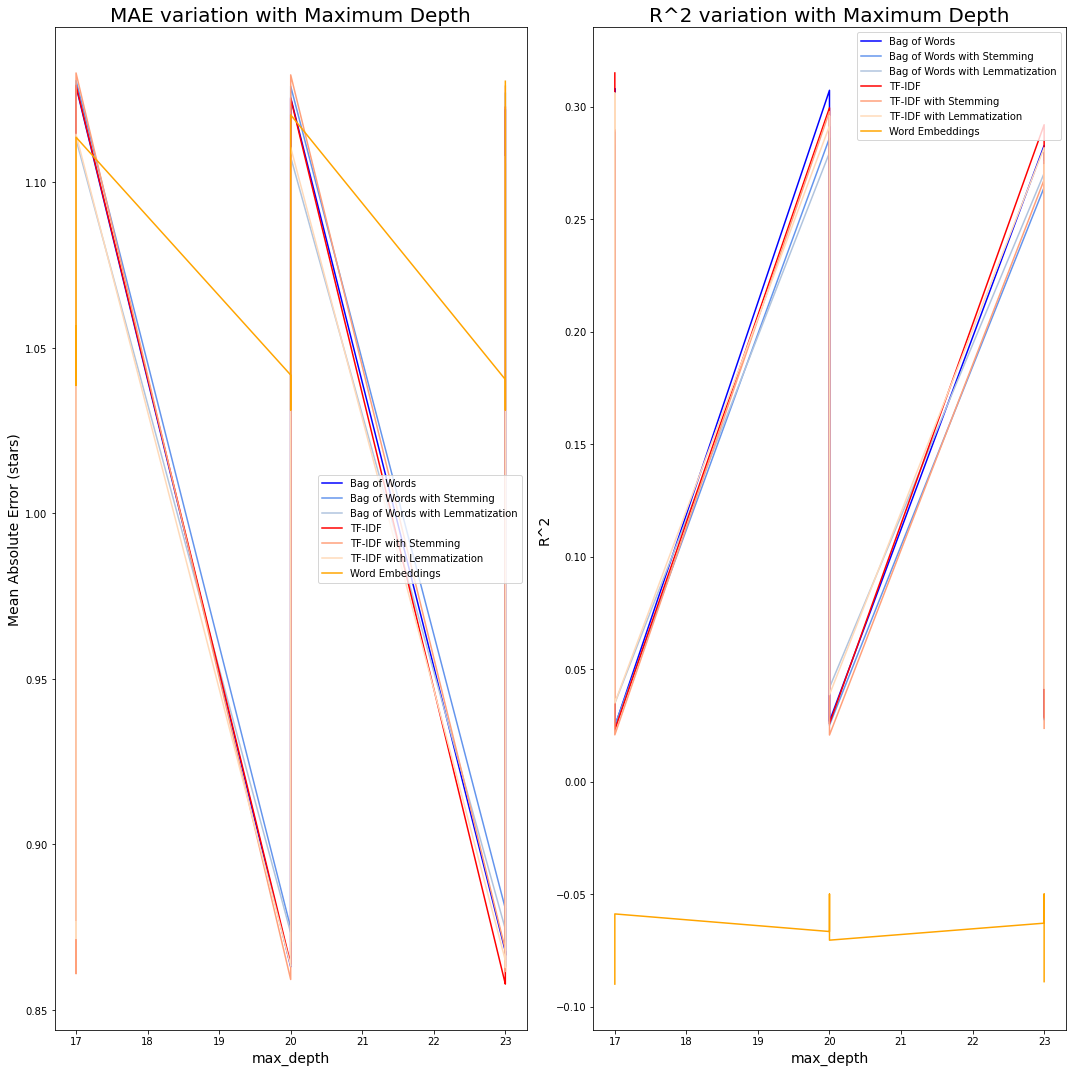

In [140]:
plt.subplots(1, 2, figsize=(15,15))

plt.subplot(1, 2, 1)
for vectorizer in temp_df['Vectorizer'].unique():
    vect_df = temp_df[temp_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['max_depth'], vect_df['MAE'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    #plt.xscale('log')
    plt.title('MAE variation with Maximum Depth', fontsize=20)
    plt.xlabel('max_depth', fontsize=14)
    plt.ylabel('Mean Absolute Error (stars)', fontsize=14)
    plt.legend()
    
plt.subplot(1, 2, 2)
for vectorizer in temp_df['Vectorizer'].unique():
    vect_df = temp_df[temp_df['Vectorizer'] == vectorizer]
    plt.plot(vect_df['max_depth'], vect_df['R2'],
             label=vectorizer_dict[vectorizer]['descriptor'], color=vectorizer_dict[vectorizer]['color'])
    #plt.xscale('log')
    plt.title('R^2 variation with Maximum Depth', fontsize=20)
    plt.xlabel('max_depth', fontsize=14)
    plt.ylabel('R^2', fontsize=14)
    plt.legend()
    

plt.tight_layout()
plt.show()

In [131]:
best_DT_pipeline = DT_grid_search.best_estimator_

In [132]:
%%time

# Fit the model
best_DT_pipeline.fit(X_train, y_train)

CPU times: user 4.95 s, sys: 168 ms, total: 5.12 s
Wall time: 5.13 s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
       

In [133]:
model_results(best_DT_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.6 stars
R^2 on train set 0.63


MAE on test set: 0.87 stars
R^2 on test set: 0.27


### Random Forests

In [119]:
pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True))
])

X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

In [122]:
%%time

forest_reg = RandomForestRegressor(max_depth=6, max_features=0.66)

forest_reg.fit(X_train_prepared, y_train)

CPU times: user 2min 5s, sys: 137 ms, total: 2min 5s
Wall time: 2min 5s


RandomForestRegressor(max_depth=6, max_features=0.66)

In [121]:
model_results(forest_reg, X_train_prepared, y_train, X_test_prepared, y_test)

MAE on train set: 0.92 stars
R^2 on train set 0.34


MAE on test set: 0.96 stars
R^2 on test set: 0.29


In [166]:
forest_pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', RandomForestRegressor())
])

param_grid = [{'model__max_depth': [20, 25, 30],
              'model__random_state': [0],   
              'model__n_estimators': [100, 300],
              'model__max_features': [0.5, 0.75, 1.0],
              'model__min_samples_leaf': [6]}]

param_grid = [{'model__max_depth': [20],
              'model__random_state': [0],   
              'model__n_estimators': [100],
              'model__max_features': [0.75],
              'model__min_samples_leaf': [6],
              'model__n_jobs': [-1]}]

forest_grid_search = GridSearchCV(forest_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4, n_jobs=-1)

In [167]:
%%time

forest_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 13min 59s, sys: 6.68 s, total: 14min 6s
Wall time: 7min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [168]:
forest_grid_search.best_score_

-0.7836265035504895

[CV 4/5] END model__max_depth=20, model__max_features=0.75, model__min_samples_leaf=6, model__n_estimators=100, model__n_jobs=-1, model__random_state=0; custom_mae_scorer: (test=-0.767) custom_r2_scorer: (test=0.490) total time= 5.5min
[CV 1/5] END model__max_depth=20, model__max_features=0.75, model__min_samples_leaf=6, model__n_estimators=100, model__n_jobs=-1, model__random_state=0; custom_mae_scorer: (test=-0.768) custom_r2_scorer: (test=0.481) total time= 5.5min
[CV 3/5] END model__max_depth=20, model__max_features=0.75, model__min_samples_leaf=6, model__n_estimators=100, model__n_jobs=-1, model__random_state=0; custom_mae_scorer: (test=-0.781) custom_r2_scorer: (test=0.493) total time= 5.5min
[CV 2/5] END model__max_depth=20, model__max_features=0.75, model__min_samples_leaf=6, model__n_estimators=100, model__n_jobs=-1, model__random_state=0; custom_mae_scorer: (test=-0.792) custom_r2_scorer: (test=0.470) total time= 5.5min
[CV 5/5] END model__max_depth=20, model__max_features=0.

In [161]:
forest_grid_search.best_score_

-0.7842935049060367

### Gradient Boost

In [196]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

param_grid = [{'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [500],
              'model__learning_rate': [0.5]},
             {'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [1000],
              'model__learning_rate': [0.1]}]

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4, n_jobs=-1)

In [197]:
%%time
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5] END model__learning_rate=0.5, model__max_depth=6, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.738) custom_r2_scorer: (test=0.503) total time=20.7min
[CV 3/5] END model__learning_rate=0.5, model__max_depth=8, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.728) custom_r2_scorer: (test=0.513) total time=26.8min
[CV 5/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.714) custom_r2_scorer: (test=0.492) total time=33.5min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.661) custom_r2_scorer: (test=0.610) total time=41.1min
[CV 4/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__

[CV 4/5] END model__learning_rate=0.5, model__max_depth=6, model__n_estimators=500, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.695) custom_r2_scorer: (test=0.544) total time=21.3min
[CV 2/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.740) custom_r2_scorer: (test=0.491) total time=33.1min
[CV 3/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.656) custom_r2_scorer: (test=0.618) total time=40.2min
[CV 5/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.637) custom_r2_scorer: (test=0.616) total time=53.8min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=10, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

[CV 2/5] END model__learning_rate=0.5, model__max_depth=8, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.738) custom_r2_scorer: (test=0.496) total time=26.9min
[CV 3/5] END model__learning_rate=0.5, model__max_depth=10, model__n_estimators=500, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.743) custom_r2_scorer: (test=0.479) total time=33.7min
[CV 5/5] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=1000, model__random_state=0, model__reg_lambda=1; custom_mae_scorer: (test=-0.636) custom_r2_scorer: (test=0.617) total time=40.4min
[CV 2/5] END model__learning_rate=0.1, model__max_depth=8, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (test=-0.665) custom_r2_scorer: (test=0.603) total time=55.4min
[CV 4/5] END model__learning_rate=0.1, model__max_depth=10, model__n_estimators=1000, model__random_state=0, model__reg_lambda=10; custom_mae_scorer: (t

In [198]:
xgb_grid_search.best_score_


-0.6442711930639955

In [199]:
xgb_grid_search.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 6,
 'model__n_estimators': 1000,
 'model__random_state': 0,
 'model__reg_lambda': 10}

In [201]:
best_xgb_pipeline = xgb_grid_search.best_estimator_

best_xgb_pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [202]:
%%time

best_xgb_pipeline.fit(X_train, y_train)

CPU times: user 55min 51s, sys: 10.8 s, total: 56min 2s
Wall time: 4min 58s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [203]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(best_xgb_pipeline.predict(X_train))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(best_xgb_pipeline.predict(X_test))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.24 stars
R^2 on train set 0.94


MAE on test set: 0.63 stars
R^2 on test set 0.64


#### Saving the Model

In [496]:
joblib.dump(best_xgb_pipeline, 'best_xgb_pipeline.pkl') 

['best_xgb_pipeline.pkl']

#### Using Optuna

In [227]:
X_rem, X_val, y_rem, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify=y_train, random_state=0)

print(f'Shape of X_rem: {X_rem.shape}. Shape of y_rem: {y_rem.shape}')
print(f'Shape of X_val: {X_val.shape}. Shape of y_val: {y_val.shape}')

Shape of X_rem: (8734, 48). Shape of y_rem: (8734,)
Shape of X_val: (2184, 48). Shape of y_val: (2184,)


In [240]:
xgb_op_pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('model', XGBRegressor(random_state=0, verbosity=1, n_jobs=-2))
])



def objective(trial):    
      

    model__max_depth = trial.suggest_int('model__max_depth', 4, 15) 
    model__n_estimators = trial.suggest_int('model__n_estimators', 500, 2000)
    model__min_child_weight=trial.suggest_int("model__min_child_weight", 1, 10)
    model__colsample_bytree=trial.suggest_float("model__colsample_bytree", 0.2, 1.0)
    model__subsample=trial.suggest_float("model__subsample", 0.2, 1.0)
    model__reg_lambda = trial.suggest_loguniform('model__reg_lambda', 1e-4, 1e2)
    model__reg_alpha = trial.suggest_loguniform('model__reg_alpha', 1e-4, 1e2)
    model__learning_rate = trial.suggest_loguniform('model__learning_rate', 1e-4, 1e-1)   
    

    params = {
        'model__max_depth': model__max_depth,
        'model__n_estimators': model__n_estimators,
        'model__min_child_weight': model__min_child_weight,
        'model__colsample_bytree': model__colsample_bytree,
        'model__subsample': model__subsample,
        'model__reg_lambda': model__reg_lambda,
        'model__reg_alpha': model__reg_alpha,
        'model__learning_rate': model__learning_rate
    }
    
    xgb_op_pipeline.set_params(**params)
    
    xgb_op_pipeline.fit(X_rem, y_rem)
    fitted_values = xgb_op_pipeline.predict(X_val)
    

    return custom_mae_scorer_func(y_val, fitted_values)

study = optuna.create_study(direction='minimize')

[I 2021-12-02 15:53:24,775] A new study created in memory with name: no-name-4330d4bd-6a67-4f05-a5da-e99a689e451f


In [241]:
%%time

study.optimize(objective, n_trials=20)

[I 2021-12-02 15:55:17,428] Trial 0 finished with value: 2.5002938146556253 and parameters: {'model__max_depth': 7, 'model__n_estimators': 878, 'model__min_child_weight': 5, 'model__colsample_bytree': 0.461620401618329, 'model__subsample': 0.9951140258691842, 'model__reg_lambda': 0.00040433347779435773, 'model__reg_alpha': 72.57795019146167, 'model__learning_rate': 0.0002765909370300346}. Best is trial 0 with value: 2.5002938146556253.
[I 2021-12-02 16:04:51,267] Trial 1 finished with value: 1.7368707759476407 and parameters: {'model__max_depth': 13, 'model__n_estimators': 1402, 'model__min_child_weight': 9, 'model__colsample_bytree': 0.9890509084039034, 'model__subsample': 0.6129912681505623, 'model__reg_lambda': 0.004600843828151683, 'model__reg_alpha': 0.07527252543173955, 'model__learning_rate': 0.00048014457143223026}. Best is trial 1 with value: 1.7368707759476407.
[I 2021-12-02 16:11:50,667] Trial 2 finished with value: 2.1800614714949997 and parameters: {'model__max_depth': 14,

[I 2021-12-02 17:16:13,355] Trial 19 finished with value: 2.6579675320194753 and parameters: {'model__max_depth': 9, 'model__n_estimators': 1163, 'model__min_child_weight': 7, 'model__colsample_bytree': 0.8134458605546275, 'model__subsample': 0.5968681613027637, 'model__reg_lambda': 0.023194685936412975, 'model__reg_alpha': 0.0032620556516422742, 'model__learning_rate': 0.00012132037720333024}. Best is trial 17 with value: 0.6502832014372933.


CPU times: user 15h 15min 31s, sys: 3min 43s, total: 15h 19min 15s
Wall time: 1h 22min 46s


In [242]:
study.best_params

{'model__max_depth': 9,
 'model__n_estimators': 1983,
 'model__min_child_weight': 7,
 'model__colsample_bytree': 0.7675589135415395,
 'model__subsample': 0.5080206234599719,
 'model__reg_lambda': 0.02129866221371885,
 'model__reg_alpha': 0.010055800687406333,
 'model__learning_rate': 0.019796486060700016}

In [246]:
study.trials_dataframe().sort_values(by='value')

,number,value,datetime_start,datetime_complete,duration,params_model__colsample_bytree,params_model__learning_rate,params_model__max_depth,params_model__min_child_weight,params_model__n_estimators,params_model__reg_alpha,params_model__reg_lambda,params_model__subsample,state
17,17,0.650283,2021-12-02 17:03:09.704326,2021-12-02 17:09:56.475821,0 days 00:06:46.771495,0.767559,0.019796,9,7,1983,0.010056,0.021299,0.508021,COMPLETE
16,16,0.652343,2021-12-02 16:58:25.348006,2021-12-02 17:03:09.703056,0 days 00:04:44.355050,0.567899,0.026427,9,7,1826,0.006609,0.000102,0.519678,COMPLETE
14,14,0.655682,2021-12-02 16:54:33.382629,2021-12-02 16:56:45.186253,0 days 00:02:11.803624,0.290383,0.020847,6,7,1989,0.018339,0.000943,0.519276,COMPLETE
11,11,0.664822,2021-12-02 16:48:29.499393,2021-12-02 16:50:12.157574,0 days 00:01:42.658181,0.539045,0.079130,4,3,1765,2.321827,0.000136,0.273586,COMPLETE
3,3,0.670755,2021-12-02 16:11:50.668245,2021-12-02 16:13:48.403066,0 days 00:01:57.734821,0.337331,0.030324,5,6,1525,2.252700,0.003611,0.873397,COMPLETE
13,13,0.674612,2021-12-02 16:51:55.438324,2021-12-02 16:54:33.381461,0 days 00:02:37.943137,0.656035,0.019707,7,2,1589,5.077328,0.006232,0.229596,COMPLETE
12,12,0.676994,2021-12-02 16:50:12.158806,2021-12-02 16:51:55.437165,0 days 00:01:43.278359,0.387079,0.077247,4,4,1707,2.130382,80.578021,0.483120,COMPLETE
10,10,0.690996,2021-12-02 16:46:53.353913,2021-12-02 16:48:29.498156,0 days 00:01:36.144243,0.537624,0.095959,4,3,1763,4.405253,0.000156,0.235748,COMPLETE
15,15,0.699247,2021-12-02 16:56:45.187559,2021-12-02 16:58:25.346797,0 days 00:01:40.159238,0.200408,0.005763,7,4,1985,0.023496,0.000599,0.340710,COMPLETE
5,5,0.700427,2021-12-02 16:18:57.158259,2021-12-02 16:23:33.649958,0 days 00:04:36.491699,0.693775,0.008002,14,9,753,0.001854,4.993588,0.680817,COMPLETE


In [249]:
xgb_op_best_pipeline = xgb_op_pipeline.set_params(**study.best_params)


In [251]:
%%time

xgb_op_best_pipeline.fit(X_train, y_train)

CPU times: user 1h 46min 24s, sys: 18.2 s, total: 1h 46min 42s
Wall time: 9min 15s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
       

In [252]:
model_results(xgb_op_best_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.34 stars
R^2 on train set 0.9


MAE on test set: 0.66 stars
R^2 on test set: 0.6


In [253]:
joblib.dump(xgb_op_best_pipeline, 'xgb_op_best_pipeline.pkl') 

['xgb_op_best_pipeline.pkl']

## Ignore

In [207]:
pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler())
])

In [ ]:
X_train_prepared = pipeline.fit_transform(X_train)

In [210]:
X_train_prepared.shape

(10918, 2825)

In [215]:
xgb_reg = XGBRegressor(learning_rate = 0.1, max_depth = 6, verbosity = 1,
                      n_estimators = 1000, random_state = 0, reg_lambda = 0)


In [216]:
%%time

xgb_reg.fit(X_train_prepared, y_train)

CPU times: user 1h 7min 13s, sys: 57.2 s, total: 1h 8min 10s
Wall time: 6min 57s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [217]:
# Print MAE and R-squared scores on both train and test sets

fitted_values = bound_predict(xgb_reg.predict(X_train_prepared))
print(f'MAE on train set: {round(custom_mae_scorer_func(y_train, fitted_values),2)} stars')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

print('\n')

fitted_values = bound_predict(xgb_reg.predict(X_test_prepared))
print(f'MAE on test set: {round(custom_mae_scorer_func(y_test, fitted_values),2)} stars')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set: 0.22 stars
R^2 on train set 0.96


MAE on test set: 0.67 stars
R^2 on test set 0.59


## Rough Work

### Optuna

In [169]:
import optuna

In [213]:
xgb_op_pipeline = Pipeline([
    ('col_trans', tfidf_lem_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=0, verbosity=1))
])

param_grid = [{'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [500],
              'model__learning_rate': [0.5]},
             {'model__max_depth': [6, 8, 10],
              'model__reg_lambda': [1, 10],
              'model__random_state': [0],   
              'model__n_estimators': [1000],
              'model__learning_rate': [0.1]}]

def objective(trial):    
      

    model__max_depth = trial.suggest_int('model__max_depth', 4, 15) 
    model__n_estimators = trial.suggest_int('model__n_estimators', 100, 1000) 
    model__reg_lambda = trial.suggest_loguniform('model__reg_lambda', 1e-6, 1e3)
    model__reg_alpha = trial.suggest_loguniform('model__reg_alpha', 1e-6, 1e3)
    model__learning_rate = trial.suggest_loguniform('model__learning_rate', 0.08, 1.0)   
    

    params = {
        'model__max_depth': model__max_depth,
        'model__n_estimators': model__n_estimators,
        'model__reg_lambda': model__reg_lambda,
        'model__reg_alpha': model__reg_alpha,
        'model__learning_rate': model__learning_rate
    }
    
    xgb_op_pipeline.set_params(**params)
    
    cv_scores = cross_validate(xgb_op_pipeline, X_train, y_train, cv=5,
                           n_jobs=-1, scoring=scorer)

    return np.mean(-cv_scores['test_custom_mae_scorer'])

study = optuna.create_study(direction='minimize')

[I 2021-12-02 01:56:36,195] A new study created in memory with name: no-name-54794f1d-c70f-4509-abaa-e8c56c35d233


In [214]:
%%time

study.optimize(objective, n_trials=15)

[I 2021-12-02 02:00:10,213] Trial 0 finished with value: 0.692423112286637 and parameters: {'model__max_depth': 4, 'model__n_estimators': 292, 'model__reg_lambda': 1.3240159221693013, 'model__reg_alpha': 9.27091755170397, 'model__learning_rate': 0.11416772124499135}. Best is trial 0 with value: 0.692423112286637.
[I 2021-12-02 02:12:31,600] Trial 1 finished with value: 0.7113656845298058 and parameters: {'model__max_depth': 6, 'model__n_estimators': 816, 'model__reg_lambda': 1.0329457637101809e-05, 'model__reg_alpha': 0.0901619860043683, 'model__learning_rate': 0.39468735466036003}. Best is trial 0 with value: 0.692423112286637.
[I 2021-12-02 02:18:42,738] Trial 2 finished with value: 0.6849793721823924 and parameters: {'model__max_depth': 4, 'model__n_estimators': 590, 'model__reg_lambda': 75.12875858939316, 'model__reg_alpha': 0.0019157553263880129, 'model__learning_rate': 0.6137881537006041}. Best is trial 2 with value: 0.6849793721823924.
[I 2021-12-02 02:20:34,188] Trial 3 finishe

CPU times: user 1.79 s, sys: 2.46 s, total: 4.25 s
Wall time: 2h 27min 11s


In [217]:
study.best_params


{'model__max_depth': 12,
 'model__n_estimators': 484,
 'model__reg_lambda': 771.3146450245019,
 'model__reg_alpha': 1.3552881879737918e-06,
 'model__learning_rate': 0.08607447447392898}

In [220]:
%%time

xgb_op_pipeline.set_params(**study.best_params)
xgb_op_pipeline.fit(X_train, y_train)

CPU times: user 45min 39s, sys: 10.9 s, total: 45min 49s
Wall time: 4min 11s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'NoiseLevel',
       

In [45]:
best_lin_reg_pipeline.named_steps['model'].coeff

Ridge(alpha=10)

In [221]:
model_results(xgb_op_pipeline, X_train, y_train, X_test, y_test)

MAE on train set: 0.4 stars
R^2 on train set 0.83


MAE on test set: 0.68 stars
R^2 on test set: 0.58


In [222]:
#import dill
import joblib

joblib.dump(xgb_op_pipeline, 'xgb_op_pipeline.pkl') 


['xgb_op_pipeline.pkl']

In [184]:
best_lin_reg = joblib.load('best_lin_reg.pkl') 

In [185]:
fitted_values = bound_predict(best_lin_reg.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.54
R^2 on train set 0.73


In [186]:
fitted_values = bound_predict(best_lin_reg.predict(X_test))
print(f'MAE on test set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on test set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.63
R^2 on train set 0.64


In [187]:
best_lin_reg

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [ ]:
param_grid = [{'max_depth': [6, 10], 'max_features': [0.33, 0.66, 1.0], 'min_samples_leaf': [4, 6]}]

grid_search = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=1000, n_jobs=-2),
                           param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)

## Word embeddings

In [55]:
import gensim

In [57]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [ ]:
from gensim.utils import simple_preprocess

def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

In [ ]:
def sent2vec_col_trans(col):
    sentence_embedding = col.apply(sentence2vec)
    return np.array(sentence_embedding.tolist())

In [86]:
sent2vec_col_trans(X_train['text'])

array([[ 0.03598166, -0.02256804,  0.08554741, ..., -0.06141166,
        -0.0056973 , -0.02998764],
       [ 0.01424908,  0.01549971,  0.06497603, ..., -0.06388011,
        -0.00621364, -0.01018079],
       [ 0.02999975, -0.00643879,  0.07745692, ..., -0.08718176,
         0.03801628, -0.00418738],
       ...,
       [ 0.03231785,  0.01041096,  0.04757428, ..., -0.04298747,
         0.03416914, -0.0211182 ],
       [ 0.04077041, -0.03544312,  0.073274  , ..., -0.09089997,
         0.00019418, -0.06062922],
       [ 0.02808957,  0.02433967,  0.07809238, ..., -0.02453979,
        -0.00635034, -0.02454223]])

In [154]:
X_train_emb = X_train['text'].apply(sentence2vec)


In [155]:
X_train_emb

118838     [0.0359816570017886, -0.022568042987924336, 0....
984277     [0.014249082192242758, 0.015499712668091366, 0...
778602     [0.029999745458784238, -0.006438788229888174, ...
483464     [0.03688956283202226, -0.03194479993967848, 0....
496132     [0.04754691617563367, 0.008007916117397448, 0....
                                 ...                        
17442      [0.02793815035270094, -0.0049136734694827265, ...
1201057    [0.019272450373027022, 0.009937714227767224, 0...
1088320    [0.032317846082150936, 0.010410956383726284, 0...
1311295    [0.04077041218748566, -0.03544312414050717, 0....
910818     [0.02808957099127451, 0.02433967230669958, 0.0...
Name: text, Length: 10918, dtype: object

In [156]:
X_train_emb = np.array(X_train_emb.tolist())

In [157]:
X_train_emb

array([[ 0.03598166, -0.02256804,  0.08554741, ..., -0.06141166,
        -0.0056973 , -0.02998764],
       [ 0.01424908,  0.01549971,  0.06497603, ..., -0.06388011,
        -0.00621364, -0.01018079],
       [ 0.02999975, -0.00643879,  0.07745692, ..., -0.08718176,
         0.03801628, -0.00418738],
       ...,
       [ 0.03231785,  0.01041096,  0.04757428, ..., -0.04298747,
         0.03416914, -0.0211182 ],
       [ 0.04077041, -0.03544312,  0.073274  , ..., -0.09089997,
         0.00019418, -0.06062922],
       [ 0.02808957,  0.02433967,  0.07809238, ..., -0.02453979,
        -0.00635034, -0.02454223]])

In [158]:
csr_matrix(X_train_emb)

<10918x300 sparse matrix of type '<class 'numpy.float64'>'
	with 3273900 stored elements in Compressed Sparse Row format>

In [87]:
sent2vec = define_col_trans('sent2vec', FunctionTransformer(sent2vec_col_trans))
sent2vec


ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 ['Year', 'Month', 'Day', 'Day of Week', 'Hour',
                                  'Minute', 'latitude', 'longitude', 'is_open',
                                  'RestaurantsGoodForGroups', 'HasTV',
                                  'GoodForKids', 'RestaurantsTakeOut',
                                  'RestaurantsPriceRange2',
                                  'RestaurantsReservations',
                                  'RestaurantsDelivery', 'OutdoorSeating',
                                  'BusinessAcceptsCreditCards', 'Sandwiches',
                                  'Pizza', 'Bars', 'American (Traditional)',
                                  'American (New)', 'Italian',
                                  'Breakfast & Brunch', 'Coffee & Tea',
                                  'Chinese', 'Seafood', 'Burgers', 'Fast Food', ...]),
                                ('category', OneHotEncoder(drop='

In [108]:
pipeline = Pipeline([
    ('col_trans', sent2vec),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('min-max-scaler', MinMaxScaler()),
    ('model', Ridge())
])

In [109]:
param_grid = [
                {
                    'model__alpha': [0.001]
                }] 


grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=4)

In [110]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__alpha=0.001; custom_mae_scorer: (test=-0.730) custom_r2_scorer: (test=0.528) total time=   7.7s
[CV 2/5] END model__alpha=0.001; custom_mae_scorer: (test=-0.741) custom_r2_scorer: (test=0.526) total time=   7.8s


KeyboardInterrupt: 

In [107]:
grid_search.best_score_

-0.6684598117186412

In [115]:
grid_search.best_params_

{'model__alpha': 0.001}

In [176]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=0, verbosity=1))
])

param_grid = [#{'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [1000], 'learning_rate': [0.1]},
             {#'model__max_depth': [6],
              'model__reg_lambda': [10],
              'model__n_estimators': [500], 'model__learning_rate': [0.1]}]

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=3, n_jobs=-2)

In [177]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.714) custom_r2_scorer: (test=0.563) total time= 2.3min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.681) custom_r2_scorer: (test=0.587) total time= 2.3min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.696) custom_r2_scorer: (test=0.572) total time= 2.3min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.706) custom_r2_scorer: (test=0.575) total time= 2.3min
CPU times: user 33min 7s, sys: 20 s, total: 33min 27s
Wall time: 13min 32s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

In [178]:
grid_search.best_score_

-0.6486781196677549

[CV 4/5] END model__learning_rate=0.1, model__n_estimators=100, model__reg_lambda=10; custom_mae_scorer: (test=-0.689) custom_r2_scorer: (test=0.581) total time= 2.3min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.654) custom_r2_scorer: (test=0.617) total time=10.3min
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.668) custom_r2_scorer: (test=0.607) total time=10.4min
[CV 4/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.639) custom_r2_scorer: (test=0.622) total time=10.4min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.638) custom_r2_scorer: (test=0.617) total time=10.4min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=10; custom_mae_scorer: (test=-0.644) custom_r2_scorer: (test=0.615) total

In [179]:
xgb_best = grid_search.best_estimator_

In [181]:
%%time

xgb_best.fit(X_train, y_train)

CPU times: user 33min 19s, sys: 16.2 s, total: 33min 35s
Wall time: 3min 5s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [182]:
fitted_values = bound_predict(xgb_best.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.34
R^2 on train set 0.88


In [183]:
fitted_values = bound_predict(xgb_best.predict(X_test))
print(f'MAE on train set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.63
R^2 on train set 0.63


In [188]:
xgb_pipeline = Pipeline([
    ('col_trans', tfidf_ct),
    ('make_array', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor(random_state=0, verbosity=1))
])

param_grid = [#{'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [1000], 'learning_rate': [0.1]},
             {#'model__max_depth': [6],
              'model__reg_lambda': [100],
              'model__n_estimators': [500], 'model__learning_rate': [0.1]}]

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=3, n_jobs=-2)

In [189]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 33min 3s, sys: 26.7 s, total: 33min 29s
Wall time: 13min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Day '
                                                                          'of '
                                                                          'Week',
                                                                          'Hour',
                                                                          'Minute',
                                                                          'latitude',
               

[CV 4/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.639) custom_r2_scorer: (test=0.626) total time=10.6min
[CV 2/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.657) custom_r2_scorer: (test=0.619) total time=10.6min
[CV 5/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.636) custom_r2_scorer: (test=0.627) total time=10.6min
[CV 3/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.647) custom_r2_scorer: (test=0.626) total time=10.6min
[CV 1/5] END model__learning_rate=0.1, model__n_estimators=500, model__reg_lambda=100; custom_mae_scorer: (test=-0.641) custom_r2_scorer: (test=0.615) total time=10.6min


In [191]:
xgb_best = grid_search.best_estimator_

In [192]:
%%time

xgb_best.fit(X_train, y_train)

CPU times: user 33min 47s, sys: 17.9 s, total: 34min 5s
Wall time: 3min 7s


Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Year', 'Month', 'Day',
                                                   'Day of Week', 'Hour',
                                                   'Minute', 'latitude',
                                                   'longitude', 'is_open',
                                                   'RestaurantsGoodForGroups',
                                                   'HasTV', 'GoodForKids',
                                                   'RestaurantsTakeOut',
                                                   'RestaurantsPriceRange2',
                                                   'RestaurantsReservations',
                                                   'RestaurantsDelivery',
                                                   'OutdoorSeating',
                                                   'BusinessAcceptsCredi

In [193]:
fitted_values = bound_predict(xgb_best.predict(X_train))
print(f'MAE on train set {round(custom_mae_scorer_func(y_train, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_train, fitted_values),2)}')

MAE on train set 0.42
R^2 on train set 0.83


In [194]:
fitted_values = bound_predict(xgb_best.predict(X_test))
print(f'MAE on train set {round(custom_mae_scorer_func(y_test, fitted_values),2)}')
print(f'R^2 on train set {round(custom_r2_scorer_func(y_test, fitted_values),2)}')

MAE on train set 0.64
R^2 on train set 0.63


In [200]:
print(xgb_best.get_params()['model'].feature_importances_)

[6.8482987e-05 5.2745261e-05 1.0994075e-04 ... 4.3695117e-04 0.0000000e+00
 0.0000000e+00]


In [202]:
from xgboost import plot_importance

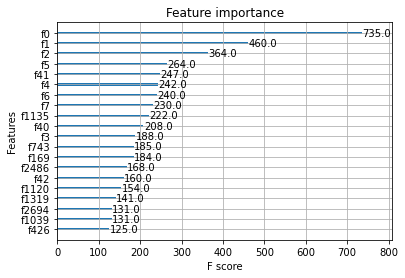

In [204]:
plot_importance(xgb_best.get_params()['model'], max_num_features=20)
plt.show()